In [9]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

class HealthDataLoader:
    """
    A class to load, preprocess, analyze, and cluster health data : heart rate (HR) and respiratory rate (RR).

    Attributes:
        root_dir (str): Root directory containing device and user data.
        device (int): Device number.
        user (int): User ID.
        days (list or None): List of specific days to load data for, or None for all available days.
        hr_data (pd.DataFrame list): List of DataFrames containing HR data for each loaded day.
        rr_data (pd.DataFrame list): List of DataFrames containing RR data for each loaded day.
    """
    def __init__(self, root_dir, device, user, days=None):
        self.root_dir = root_dir
        self.device = device
        self.user = user
        self.days = days
        self.hr_data, self.rr_data = self.load_data(root_dir, device, user, days)
        
        # Concatenate and preprocess data during initialization
        self.hr_data = pd.concat(self.hr_data, ignore_index=True)
        self.rr_data = pd.concat(self.rr_data, ignore_index=True)
        self.hr_data = self.preprocess_data(self.hr_data)
        self.rr_data = self.preprocess_data(self.rr_data)

    @staticmethod
    def load_data(root_dir, device, user, days=None):
        """
        Load data HR and RR from specified device, user, and days.

        Args:
            root_dir (str): Root directory containing device and user data.
            device (int): Device number.
            user (int): User ID.
            days (list or None): List of specific days to load data for, or None for all available days.

        Returns:
            hr_objects (list): List of HR data DataFrames.
            rr_objects (list): List of RR data DataFrames.
        """
        hr_objects = []
        rr_objects = []

        # Construct the base directory path
        device_path = os.path.join(root_dir, f'device_{device:02}')
        if not os.path.exists(device_path):
            raise ValueError(f"Device {device} does not exist.")

        user_path = os.path.join(device_path, f'user_{user:03}')
        if not os.path.exists(user_path):
            raise ValueError(f"User {user} does not exist for device {device}.")

        if days is None:
            hr_files = [file_name for file_name in os.listdir(user_path) if file_name.startswith('hr') and file_name.endswith('.csv')]
            rr_files = [file_name for file_name in os.listdir(user_path) if file_name.startswith('rr') and file_name.endswith('.csv')]
        else:
            if days == 'all':
                days = range(1, 31)
            hr_files = [f'hr_day_{day:02}.csv' for day in days]
            rr_files = [f'rr_day_{day:02}.csv' for day in days]

        # Load HR data
        for file_name in tqdm(hr_files, desc='Loading HR data'):
            file_path = os.path.join(user_path, file_name)
            if os.path.exists(file_path):
                hr_data = pd.read_csv(file_path)
                hr_objects.append(hr_data)
            else:
                print(f"HR file {file_name} does not exist.")
        
        # Load RR data
        for file_name in tqdm(rr_files, desc='Loading RR data'):
            file_path = os.path.join(user_path, file_name)
            if os.path.exists(file_path):
                rr_data = pd.read_csv(file_path)
                rr_objects.append(rr_data)
            else:
                print(f"RR file {file_name} does not exist.")

        return hr_objects, rr_objects

    @staticmethod
    def preprocess_data(data):
        """
        Preprocess the data by converting date column to datetime format, handling zero values, and filling missing values.

        Args:
            data (pd.DataFrame): Input DataFrame containing 'date' and 'value' columns.

        Returns:
            pd.DataFrame: Preprocessed DataFrame.
        """
    # Convert 'date' column to datetime format
        data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
        
        # Compute mean excluding zeros
        non_zero_mean = data[data['value'] != 0]['value'].mean()
        
        # Replace zeros with computed mean
        data.loc[data['value'] == 0, 'value'] = non_zero_mean
        
        # Fill missing values with overall mean
        overall_mean = data['value'].mean()
        data['value'] = data['value'].fillna(overall_mean)
        
        return data
    
    def analyze_data(self):
        """
        Analyze HR and RR data by plotting over time and by hour of the day.
        """        
        # Group by 'date' and calculate statistics
        hr_grouped = self.hr_data.groupby('date')['value'].agg(['mean', 'std', 'min', 'max']).reset_index()
        rr_grouped = self.rr_data.groupby('date')['value'].agg(['mean', 'std', 'min', 'max']).reset_index()
    
        
        # Plot HR and RR trends over time
        plt.figure(figsize=(14, 7))
        plt.plot(hr_grouped['date'], hr_grouped['mean'], label='HR Mean')
        plt.fill_between(hr_grouped['date'], hr_grouped['min'], hr_grouped['max'], alpha=0.3)
        plt.plot(rr_grouped['date'], rr_grouped['mean'], label='RR Mean', color='orange')
        plt.fill_between(rr_grouped['date'], rr_grouped['min'], rr_grouped['max'], alpha=0.3, color='orange')
        plt.title('HR and RR Trends Over Each Day')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.xticks(pd.date_range(start=hr_grouped['date'].min(), end=hr_grouped['date'].max(), freq='D'), rotation=45)
        plt.legend()
        plt.show()
        
        unique_dates = hr_grouped['date'].unique()


       # Analyze HR and RR patterns by hour of the day
        self.hr_data['hour'] = self.hr_data['minute'] // 60
        self.rr_data['hour'] = self.rr_data['minute'] // 60
        
        # Define styles and colors
        styles = ['-', '--', '-.', ':']
        colors = ['blue', 'green', 'red', 'purple']
        
        # Plot HR by hour of the day for all dates combined
        plt.figure(figsize=(14, 7))
        for i, date in enumerate(unique_dates):
            hr_daily = self.hr_data[self.hr_data['date'] == date]
            hr_hourly = hr_daily.groupby('hour')['value'].mean().reset_index()
            plt.plot(hr_hourly['hour'], hr_hourly['value'], 
                    label=f'HR by Hour - {date.strftime("%d-%m-%Y")}', 
                    linestyle=styles[i % len(styles)], 
                    color=colors[i % len(colors)])
        plt.title('HR by Hour of the Day (Combined for All Dates)')
        plt.xlabel('Hour')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
        # Plot RR by hour of the day for all dates combined
        plt.figure(figsize=(14, 7))
        for i, date in enumerate(unique_dates):
            rr_daily = self.rr_data[self.rr_data['date'] == date]
            rr_hourly = rr_daily.groupby('hour')['value'].mean().reset_index()
            plt.plot(rr_hourly['hour'], rr_hourly['value'], 
                    label=f'RR by Hour - {date.strftime("%d-%m-%Y")}', 
                    linestyle=styles[i % len(styles)], 
                    color=colors[i % len(colors)])
        plt.title('RR by Hour of the Day (Combined for All Dates)')
        plt.xlabel('Hour')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
    def calculate_correlations(self):
        """
        Calculate correlations between HR and RR data for day time, night time, and hourly intervals.
        Print and return the correlations.
        """
        day_correlations = []
        night_correlations = []
        hourly_correlations = []

        unique_dates = self.hr_data['date'].unique()

        for date in unique_dates:
            # Filter heart rate and respiratory rate data for the current date
            hr_daily = self.hr_data[self.hr_data['date'] == date]
            rr_daily = self.rr_data[self.rr_data['date'] == date]

            # Merge heart rate and respiratory rate data for the current date
            combined_data = pd.merge(hr_daily, rr_daily, on=['date', 'minute'], suffixes=('_hr', '_rr'))

            # Convert date and minute to datetime
            combined_data['timestamp'] = pd.to_datetime(combined_data['date'], format='%d.%m.%Y') + pd.to_timedelta(combined_data['minute'], unit='m')

            # Set the timestamp as the index
            combined_data.set_index('timestamp', inplace=True)

            # Define day time vs. night time
            combined_data['day_night'] = combined_data.index.map(lambda x: 'day' if 6 <= x.hour < 18 else 'night')

            # Define hourly
            combined_data['hour'] = combined_data.index.hour  # Ensure 'hour' column is correctly defined

            # Calculate day time vs. night time correlation
            day_data = combined_data[combined_data['day_night'] == 'day']
            night_data = combined_data[combined_data['day_night'] == 'night']

            day_correlation = day_data['value_hr'].corr(day_data['value_rr'])
            night_correlation = night_data['value_hr'].corr(night_data['value_rr'])

            day_correlations.append(day_correlation)
            night_correlations.append(night_correlation)

            # Calculate hourly correlation for the current date
            hourly_corr = combined_data.groupby('hour').apply(lambda x: x['value_hr'].corr(x['value_rr']))
            hourly_correlations.extend(hourly_corr.tolist())

            #Print correlations for the current date
            print(f'Correlations for {date.strftime("%d-%m-%Y")}:')
            print(f'Day Time Correlation: {round(day_correlation, 2)}')
            print(f'Night Time Correlation: {round(night_correlation, 2)}')
            print("------------------------------------")

    def cluster_data(self):
        """
        Cluster the combined HR and RR data for each date using KMeans clustering.

        The method performs the following steps:
        1. Merges HR and RR data based on 'date' and 'minute'.
        2. Converts 'date' and 'minute' to datetime format.
        3. Groups data by 'date'.
        4. Applies KMeans clustering to each group, determines optimal number of clusters using the elbow method,
           and visualizes the clustering results.

        Plots are displayed for each date showing the clusters of HR vs. RR values.
        """
        # Merge heart rate and respiratory rate data
        combined_data = pd.merge(self.hr_data, self.rr_data, on=['date', 'minute'], suffixes=('_hr', '_rr'))

        # Convert date and minute to datetime
        combined_data['timestamp'] = pd.to_datetime(combined_data['date'], format='%d.%m.%Y') + pd.to_timedelta(combined_data['minute'], unit='m')

        # Group data by date
        grouped = combined_data.groupby('date')
        
        # Prepare a DataFrame to hold clustering results
        cluster_results = pd.DataFrame()

        for name, group in grouped:
            if len(group) > 1:  # Need at least two points to cluster
                X = group[['value_hr', 'value_rr']]
                clusters = []
                for i in range(1, 11):
                    km = KMeans(n_clusters=i).fit(X)
                    clusters.append(km.inertia_)

                # Plot elbow method
                fig, ax = plt.subplots(figsize=(12, 8))
                sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
                ax.set_title(f'Elbow Method for Clustering - {name}')
                ax.set_xlabel('Clusters')
                ax.set_ylabel('Inertia')
                plt.show()

                # Perform KMeans clustering with the chosen number of clusters
                kmeans = KMeans(n_clusters=2).fit(X)  # Adjust number of clusters based on elbow plot
                group['cluster'] = kmeans.labels_
                cluster_results = pd.concat([cluster_results, group])

        self.visualize_clusters(cluster_results)
        
    @staticmethod
    def visualize_clusters(cluster_results):
        grouped = cluster_results.groupby('date')

        for name, group in grouped:
            plt.figure(figsize=(10, 6))
            plt.scatter(group['value_hr'], group['value_rr'], c=group['cluster'], cmap='viridis', label=name)
            plt.title(f'Clusters for {name}')
            plt.xlabel('Heart Rate')
            plt.ylabel('Respiratory Rate')
            plt.colorbar(label='Cluster')
            plt.legend()
            plt.show()

In [10]:
root_directory = 'ECG_data'
device_number = 1
user_number = 1
days=None

# Initialize the HealthDataLoader instance
loader = HealthDataLoader(root_dir=root_directory, device=device_number, user=user_number, days=days)




Loading RR data: 100%|██████████| 2/2 [00:00<00:00, 292.57it/s]


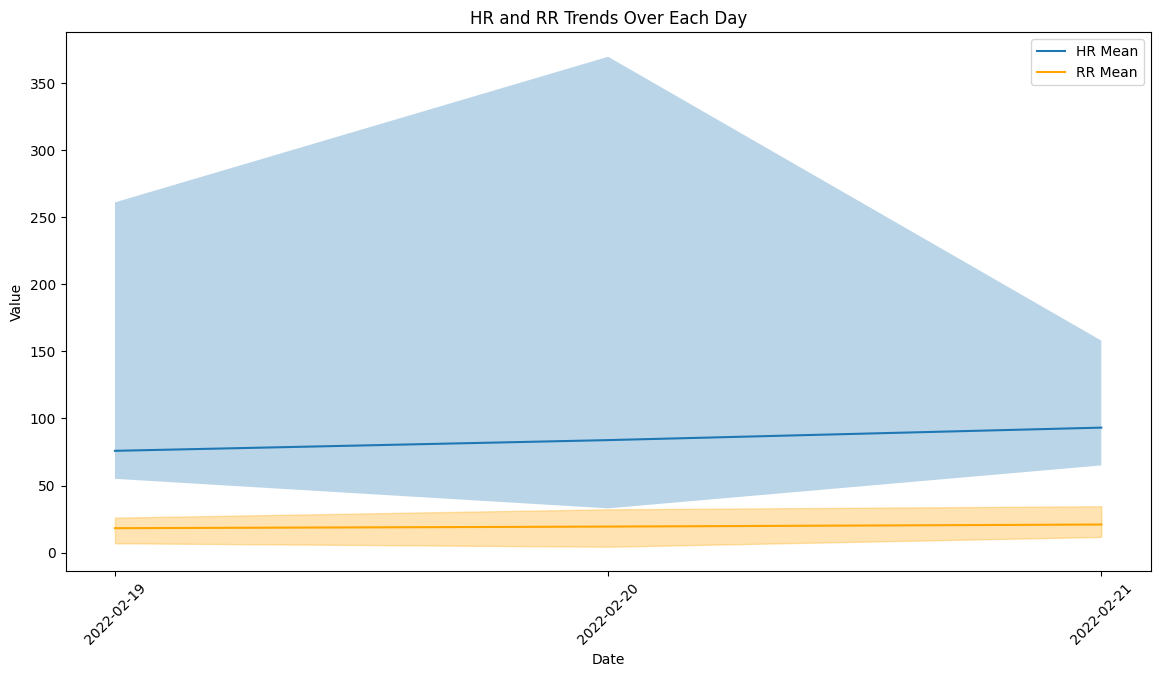

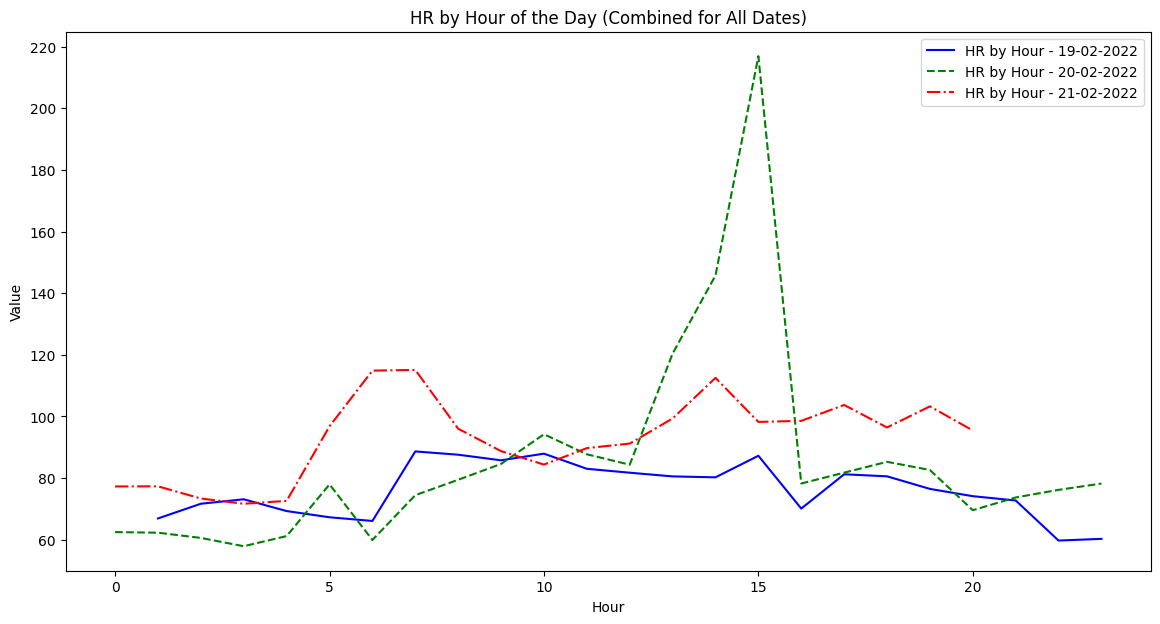

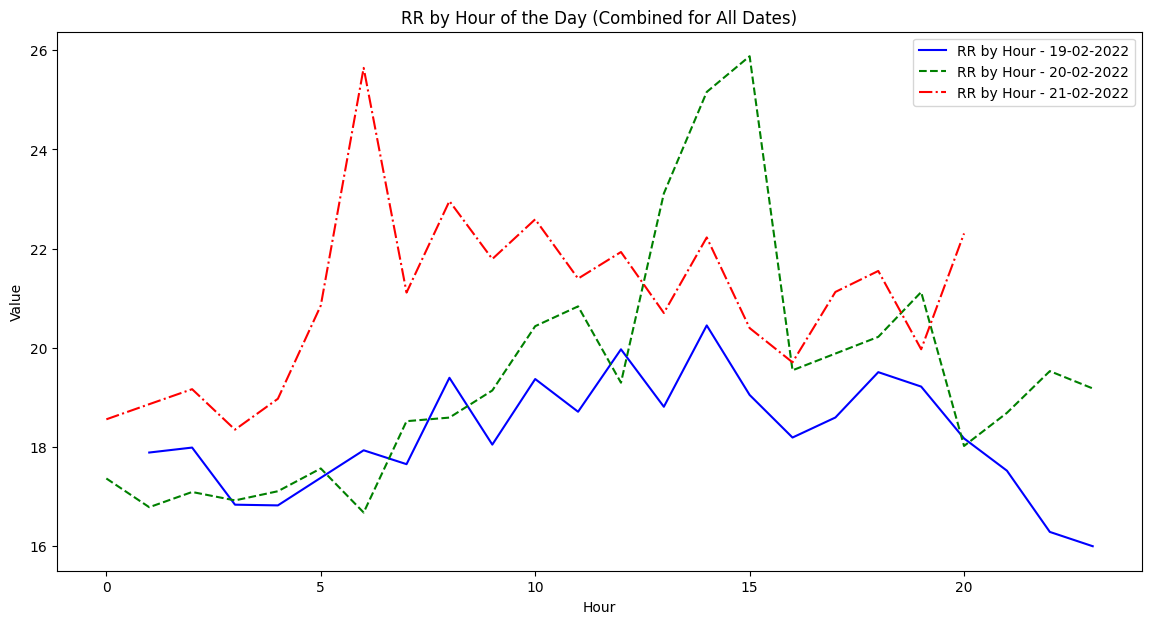

In [11]:
# Analyze and visualize the data
loader.analyze_data()

In [14]:

# Correlation Analysis
loader.calculate_correlations()

Correlations for 19-02-2022:
Day Time Correlation: 0.07
Night Time Correlation: 0.26
------------------------------------
Correlations for 20-02-2022:
Day Time Correlation: 0.56
Night Time Correlation: 0.48
------------------------------------
Correlations for 21-02-2022:
Day Time Correlation: 0.26
Night Time Correlation: 0.54
------------------------------------


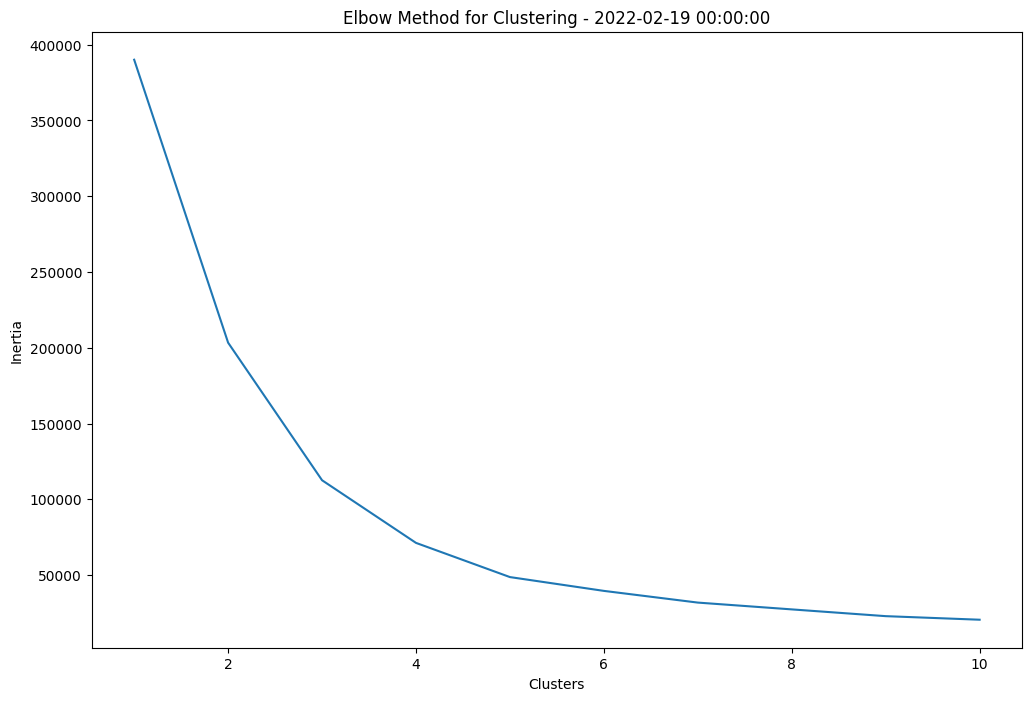

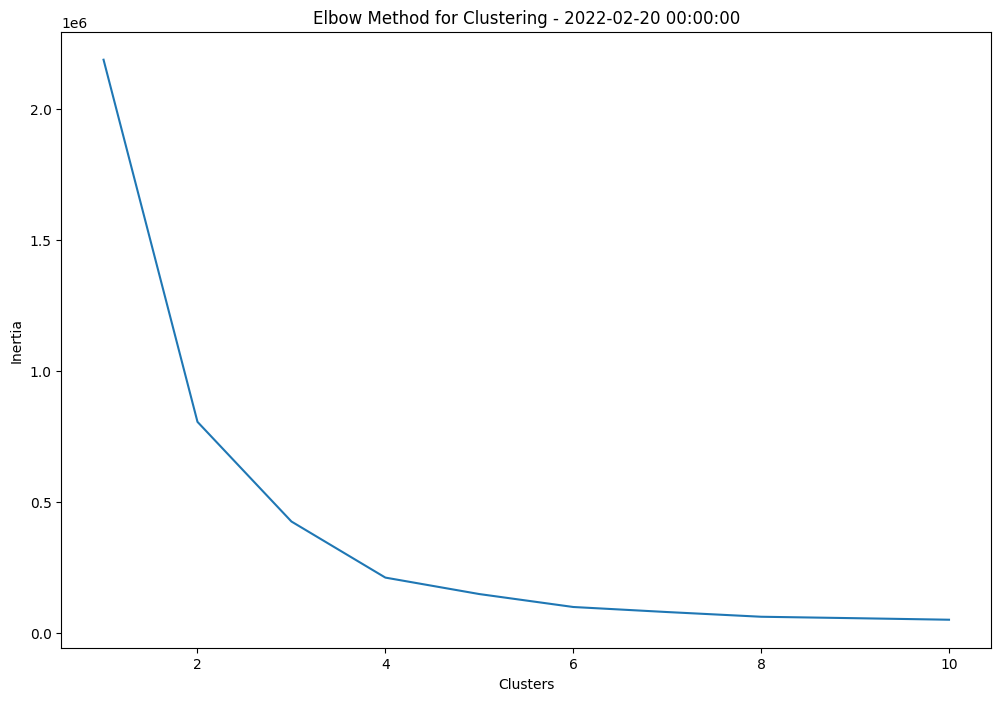

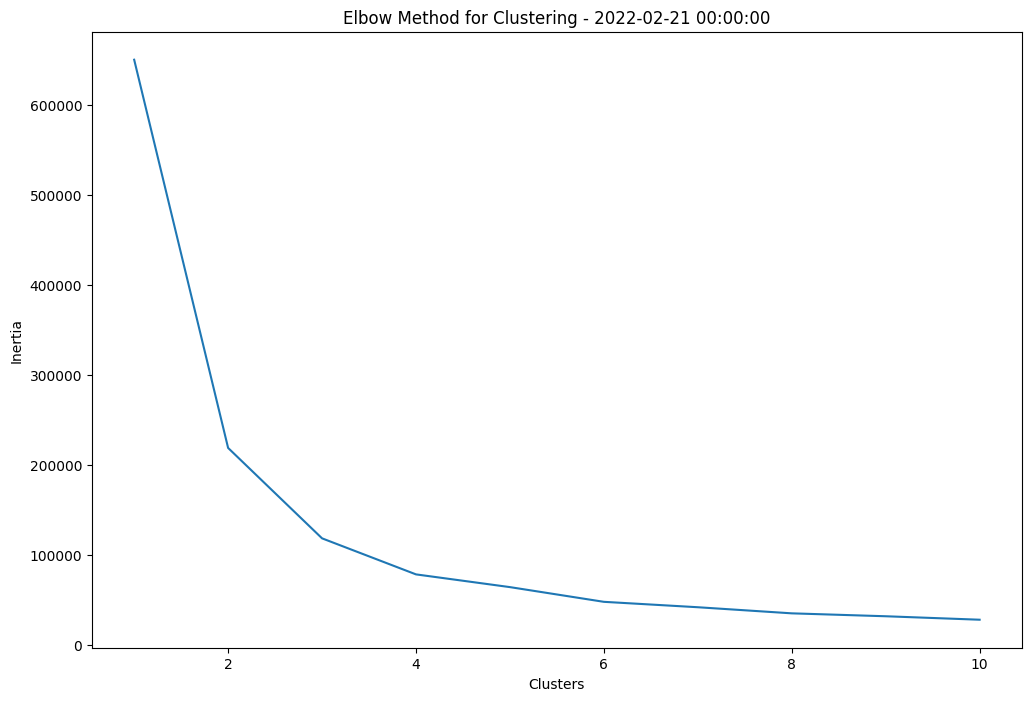

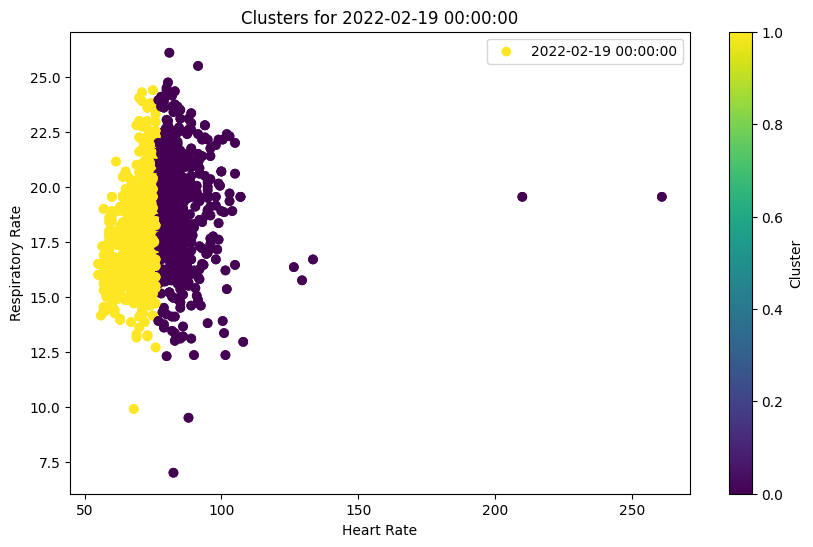

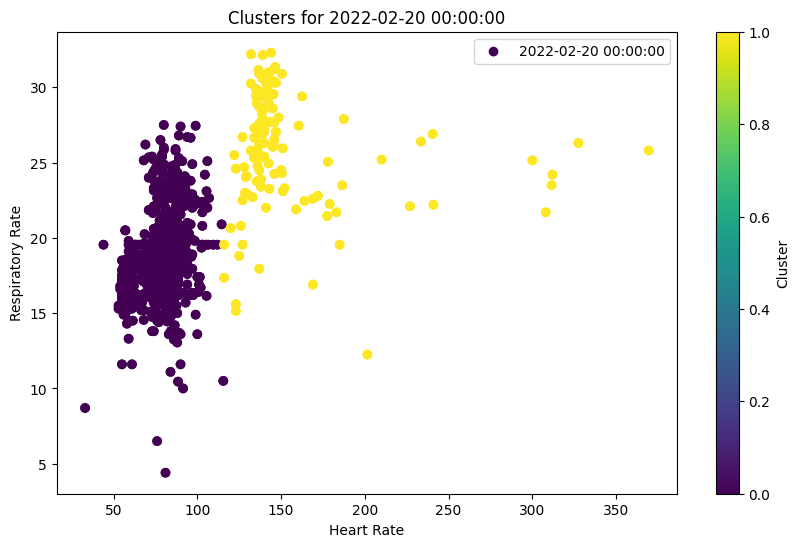

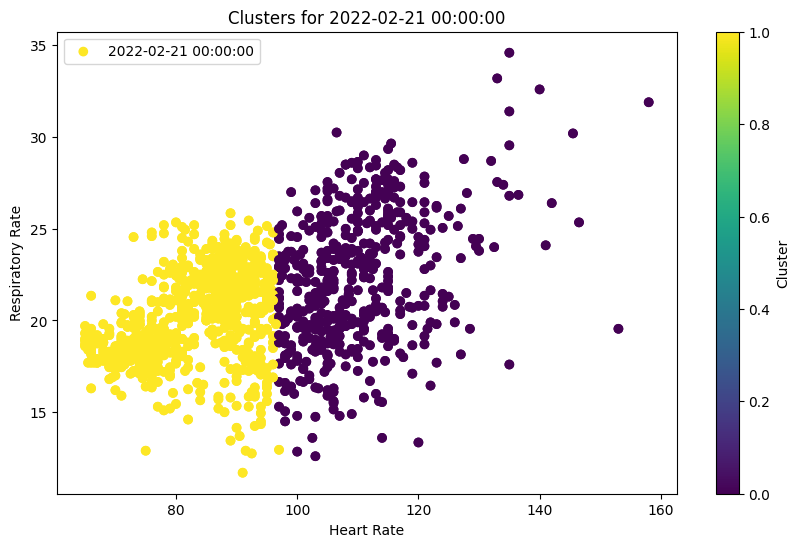

In [15]:
# Cluster the HR and RR data
loader.cluster_data()